In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from IPython.display import display


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load Dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, binary=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.binary = binary
        self.dataset = 'appa-real' if 'appa' in csv_file else 'UTKFace'

       # Add a 'label' column to the DataFrame
        if self.binary:
            self.data['label'] = self.data['real_age'].apply(lambda age: 0 if age < 25 else 1)
            self.classes = self.data['label'].unique().tolist()
        else:
            self.data['label'] = self.data['real_age']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        if self.dataset=='appa-real':
            img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg' # This is for APPA-Real
        else:
            img_path = os.path.join(self.image_dir, row['file_name']) # This is for UTKFace
        label = row['label']

        # Load image
        #image = Image.open(img_path).convert('RGB')  # Load RGB
        image = decode_jpeg(read_file(img_path), device="cpu").to('cuda')
        image = image.float() / image.max() # 255.0 # try normalising by max value in image
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.dataset == 'UTKFace':
            return image, label, row['gender'], row['race']
        return image, label


        
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dir = './UTKFace/crop_part1'
test_csv = './UTKFace/test.csv'
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=True
)

Race Breakdown in the Training Dataset:
race_label
White     2909
Indian     709
Asian      616
Other      519
Black      218
Name: count, dtype: int64


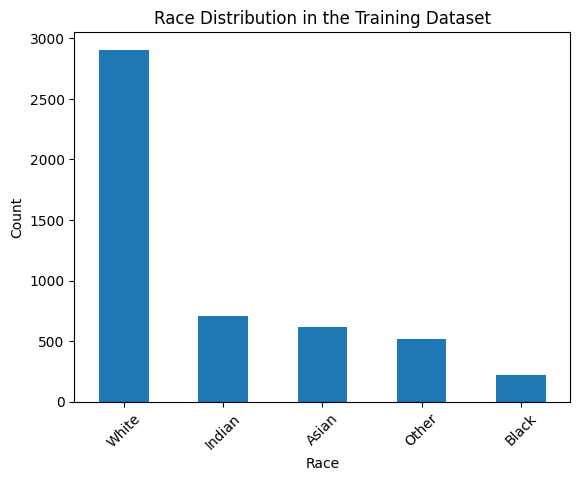

In [97]:
# Load the training dataset CSV file
train_csv = './UTKFace/train.csv'
train_data = pd.read_csv(train_csv)

# Map numeric race values to their corresponding labels
race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}

# Convert numeric race values to labels
train_data['race_label'] = train_data['race'].map(race_labels)

# Check the distribution of races
race_counts = train_data['race_label'].value_counts()

# Display the breakdown of races
print("Race Breakdown in the Training Dataset:")
print(race_counts)

# Plot the distribution with race labels on the x-axis
race_counts.plot(kind='bar', title='Race Distribution in the Training Dataset', xlabel='Race', ylabel='Count')

# Customizing the x-axis with the race labels
plt.xticks(rotation=45)
plt.xlabel("Race")
plt.ylabel("Count")
plt.show()


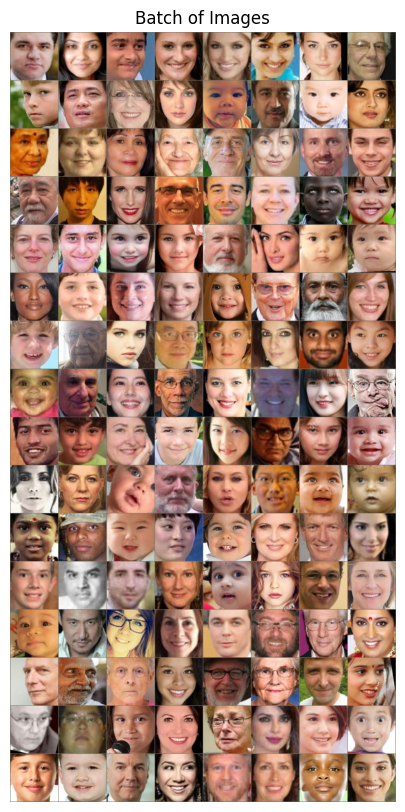

Labels for the batch: tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1])


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as T

# Get a single batch from the DataLoader
data_iter = iter(test_loader)
images, labels, gender, race = next(data_iter)

# Convert the batch of images to a grid for easier visualization
grid = torchvision.utils.make_grid(images.cpu(), nrow=8, padding=2)

# Convert tensor to NumPy array for display
grid = grid.permute(1, 2, 0).numpy()

# Normalize the image back to [0, 1] for visualization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
grid = std * grid + mean  # Reversing normalization

# Clip values to [0, 1]
grid = np.clip(grid, 0, 1)

# Plot the image grid
plt.figure(figsize=(10, 10))
plt.imshow(grid)
plt.title('Batch of Images')
plt.axis('off')
plt.show()

# Print labels for the batch
print("Labels for the batch:", labels)

# Bias investigation

## Binary Classification Model

In [6]:
from collections import defaultdict

def test_binary(model, device, test_loader, criterion, decision_boundary=0.7):
    model.eval()  # Set model to evaluation mode

    test_loss = 0
    correct = 0
    all_targets = []
    all_preds = []
    all_probs = []

    # Track results for each gender and race
    gender_stats = defaultdict(lambda: {"targets": [], "preds": [], "probs": []})
    race_stats = defaultdict(lambda: {"targets": [], "preds": [], "probs": []})

    with torch.no_grad():
        for data, target, gender, race in test_loader:
            data, target, gender, race = data.to(device), target.to(device), gender.to(device), race.to(device)

            # Compute loss
            output = model(data)  # Output is logits       
            test_loss += criterion(output.squeeze(), target.float()).item()  # Sum up batch loss
            
            # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)

            # Get predictions by thresholding at 0.5
            pred = (output > decision_boundary).float()

            # Store overall stats
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(output.cpu().numpy())

            # Store stats for gender and race
            for i in range(len(target)):
                gender_id = int(gender[i].item())  # Ensure it's an integer
                race_id = int(race[i].item())  # Ensure it's an integer
                
                gender_stats[gender_id]["targets"].append(target[i].item())
                gender_stats[gender_id]["preds"].append(pred[i].item())
                gender_stats[gender_id]["probs"].append(output[i].item())

                race_stats[race_id]["targets"].append(target[i].item())
                race_stats[race_id]["preds"].append(pred[i].item())
                race_stats[race_id]["probs"].append(output[i].item())

            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute overall metrics
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
    auc_roc = auc(fpr, tpr)

    # Compute metrics for each gender
    gender_results = {}
    for gender, data in gender_stats.items():
        gender_results[gender] = compute_metrics(data["targets"], data["preds"], data["probs"])

    # Compute metrics for each race
    race_results = {}
    for race, data in race_stats.items():
        race_results[race] = compute_metrics(data["targets"], data["preds"], data["probs"])

    return {
        "overall": {
            "loss": round(test_loss,3),
            "accuracy": round(test_accuracy,3),
            "precision": round(precision,3),
            "recall": round(recall,3),
            "f1_score": round(f1,3),
            "confusion_matrix": (tn, fp, fn, tp),
            "auc_roc": round(auc_roc,3),
            "fpr": round(fp/(fp+tn),3)
        },
        "gender_results": gender_results,
        "race_results": race_results,
    }

def compute_metrics(targets, preds, probs):
    """Helper function to compute metrics for subgroups (gender/race)."""
    if len(targets) == 0:  # Avoid division by zero
        return {"accuracy": None, "precision": None, "recall": None, "f1_score": None, "auc_roc": None}

    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, zero_division=0)
    recall = recall_score(targets, preds, zero_division=0)
    f1 = f1_score(targets, preds, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(targets, preds).ravel()
    fpr, tpr, _ = roc_curve(targets, probs)
    auc_roc = auc(fpr, tpr)

    return {
        "accuracy": round(accuracy,3),
        "precision": round(precision,3),
        "recall": round(recall,3),
        "f1_score": round(f1,3),
        "confusion_matrix": (tn, fp, fn, tp),
        "auc_roc": round(auc_roc,3),
        "fpr": round(fp/(fp+tn),3)
    }


In [9]:
# Change to apropriate model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

model.fc = nn.Linear(num_features, 1)

# saved_model_path = './models/UTKFaceTrained/binary/ResNet50_fc+layer4_v3.pth'
saved_model_path = './models/ResNet50_fc+layer4_2025-01-22_v1.pth'
model.load_state_dict(torch.load(saved_model_path, weights_only=True))
model.to(device)
model.eval()

# If you saved the model on a GPU and are loading it on a CPU, you can specify:
# model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

test_results = test_binary(model, device, test_loader, criterion = nn.BCEWithLogitsLoss())

Number of features from pre-trained model 2048


In [10]:
overall_metrics = {key: value for key, value in test_results["overall"].items() if key != "confusion_matrix"}
overall_df = pd.DataFrame(overall_metrics, index=[0])
print("Overall Performance:")
display(overall_df)

# Gender-specific results
gender_data = []
for gender, metrics in test_results["gender_results"].items():
    gender_label = "Female" if gender else "Male"
    gender_data.append({"Gender": gender_label, **metrics})
gender_df = pd.DataFrame(gender_data)
print("\nPerformance by Gender:")
display(gender_df.drop(columns=['confusion_matrix']).sort_values(by="f1_score", ascending=False))

# Race-specific results
race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
race_data = []
for race, metrics in test_results["race_results"].items():
    race_label = race_labels.get(race, "Unknown")
    race_data.append({"Race": race_label, **metrics})
race_df = pd.DataFrame(race_data)
print("\nPerformance by Race:")
display(race_df.drop(columns=['confusion_matrix']).sort_values(by="f1_score", ascending=False))

Overall Performance:


,loss,accuracy,precision,recall,f1_score,auc_roc,fpr
0,0.555,83.172,0.894,0.815,0.853,0.919,0.144



Performance by Gender:


,Gender,accuracy,precision,recall,f1_score,auc_roc,fpr
1,Male,0.919,0.936,0.936,0.936,0.975,0.111
0,Female,0.765,0.850,0.712,0.775,0.863,0.165



Performance by Race:


,Race,accuracy,precision,recall,f1_score,auc_roc,fpr
1,White,0.878,0.938,0.877,0.907,0.954,0.121
4,Black,0.824,0.900,0.818,0.857,0.910,0.167
2,Indian,0.731,0.798,0.723,0.759,0.806,0.258
0,Other,0.804,0.728,0.776,0.752,0.891,0.179
3,Asian,0.766,0.864,0.554,0.675,0.867,0.068


In [11]:
overall_df = pd.DataFrame.from_dict(test_results["overall"])
tn, fp, fn, tp = overall_df['confusion_matrix']
conf_matrix_df = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    columns=["Pred 0", "Pred 1"],
    index=["Act 0", "Act 1"]
)

# Normalize by total sum
conf_matrix_total = round(conf_matrix_df / conf_matrix_df.values.sum(),2)

print('Combined Confusion Matrix:')
display(conf_matrix_total)

Combined Confusion Matrix:


,Pred 0,Pred 1
Act 0,0.34,0.06
Act 1,0.11,0.49


In [19]:
def load_and_test_model(model_path, test_loader, device):
    """Loads a ResNet50 model, tests it, and returns performance metrics."""
    # Load ResNet50
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)  # Modify output layer for binary classification
    
    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()

    # Evaluate on test data
    test_results = test_binary(model, device, test_loader, criterion=nn.BCEWithLogitsLoss())
    
    return test_results

# List of models to compare
model_paths = {
    "APPA-Real Trained": "./models/ResNet50_fc+layer4_2025-01-22_v1.pth",
    "UTKFace Trained": './models/UTKFaceTrained/binary/ResNet50_fc+layer4_v3.pth'
}

# Dictionary to store results for each model
results = {}

for model_name, model_path in model_paths.items():
    print(f"Evaluating {model_name}...")
    results[model_name] = load_and_test_model(model_path, test_loader, device)


Evaluating APPA-Real Trained...
Evaluating UTKFace Trained...


In [20]:
overall_dfs = []

for model_name, test_results in results.items():
    overall_metrics = {key: value for key, value in test_results["overall"].items() if key != "confusion_matrix"}
    df = pd.DataFrame(overall_metrics, index=[model_name])
    overall_dfs.append(df)

overall_df = pd.concat(overall_dfs)
print("Overall Performance:")
display(overall_df)

gender_dfs = []

for model_name, test_results in results.items():
    gender_data = []
    for gender, metrics in test_results["gender_results"].items():
        gender_label = "Female" if gender else "Male"
        gender_data.append({"Model": model_name, "Gender": gender_label, **metrics})
    
    df = pd.DataFrame(gender_data).drop(columns=["confusion_matrix"])
    gender_dfs.append(df)

gender_df = pd.concat(gender_dfs)
print("\nPerformance by Gender:")
display(gender_df.sort_values(by=["Gender", "f1_score"], ascending=[True, False]))

race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
race_dfs = []

for model_name, test_results in results.items():
    race_data = []
    for race, metrics in test_results["race_results"].items():
        race_label = race_labels.get(race, "Unknown")
        race_data.append({"Model": model_name, "Race": race_label, **metrics})
    
    df = pd.DataFrame(race_data).drop(columns=["confusion_matrix"])
    race_dfs.append(df)

race_df = pd.concat(race_dfs)
print("\nPerformance by Race:")
display(race_df.sort_values(by=["Race", "f1_score"], ascending=[True, False]))


Overall Performance:


,loss,accuracy,precision,recall,f1_score,auc_roc,fpr
APPA-Real Trained,0.555,83.172,0.894,0.815,0.853,0.919,0.144
UTKFace Trained,0.355,88.118,0.895,0.907,0.901,0.955,0.157



Performance by Gender:


,Model,Gender,accuracy,precision,recall,f1_score,auc_roc,fpr
0,UTKFace Trained,Female,0.845,0.857,0.873,0.865,0.927,0.192
1,APPA-Real Trained,Female,0.765,0.850,0.712,0.775,0.863,0.165
1,UTKFace Trained,Male,0.929,0.941,0.947,0.944,0.981,0.103
0,APPA-Real Trained,Male,0.919,0.936,0.936,0.936,0.975,0.111



Performance by Race:


,Model,Race,accuracy,precision,recall,f1_score,auc_roc,fpr
1,UTKFace Trained,Asian,0.818,0.846,0.717,0.776,0.911,0.103
4,APPA-Real Trained,Asian,0.766,0.864,0.554,0.675,0.867,0.068
3,UTKFace Trained,Black,0.912,0.913,0.955,0.933,0.943,0.167
0,APPA-Real Trained,Black,0.824,0.900,0.818,0.857,0.910,0.167
0,UTKFace Trained,Indian,0.808,0.807,0.883,0.843,0.894,0.299
2,APPA-Real Trained,Indian,0.731,0.798,0.723,0.759,0.806,0.258
4,UTKFace Trained,Other,0.824,0.725,0.868,0.790,0.920,0.203
3,APPA-Real Trained,Other,0.804,0.728,0.776,0.752,0.891,0.179
2,UTKFace Trained,White,0.923,0.945,0.941,0.943,0.980,0.114
1,APPA-Real Trained,White,0.878,0.938,0.877,0.907,0.954,0.121


In [31]:
# Pivot the race_df to show models side by side
race_pivot_df = race_df.pivot(index="Race", columns="Model", values="f1_score")
race_pivot_df = race_pivot_df.sort_values(by=race_pivot_df.columns.max(), ascending=False)

# Display the formatted table
display(race_pivot_df)

Model,APPA-Real Trained,UTKFace Trained
Race,,
White,0.907,0.943
Black,0.857,0.933
Indian,0.759,0.843
Other,0.752,0.790
Asian,0.675,0.776


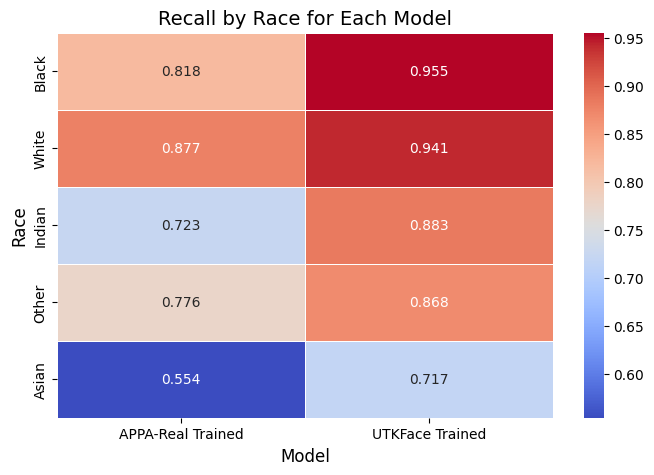

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt


# Choose the metric you want to sort by
metric_to_sort = "recall"  # Change to "recall" or "auc_roc" if needed

# Pivot table for F1-score
race_pivot_df = race_df.pivot(index="Race", columns="Model", values=metric_to_sort)

# Sort the rows by highest F1-score across models
race_pivot_df = race_pivot_df.sort_values(by=race_pivot_df.columns.max(), ascending=False)

# Create a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(race_pivot_df, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)

# Labels and title
plt.title(f"{metric_to_sort.capitalize()} by Race for Each Model", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Race", fontsize=12)

# Show the heatmap
plt.show()


## Multiclass Model

In [59]:
# Chagen the dataset to use real ages
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms, binary=False)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=True
)

In [62]:
def test_multiclass(model, device, test_loader, criterion):
    model.eval()  # Set model to evaluation mode

    test_loss = 0
    correct = 0
    all_targets = []
    all_preds = []

    # Track results for each gender and race
    gender_stats = defaultdict(lambda: {"targets": [], "preds": []})
    race_stats = defaultdict(lambda: {"targets": [], "preds": []})
    bins = torch.tensor([18, 28, 40], device=device)  # Define bin edges

    with torch.no_grad():
        for data, target, gender, race in test_loader:
            data, target = data.to(device), target.to(device)
            gender, race = gender.cpu().numpy(), race.cpu().numpy()
            # Convert continuous ages into bins (0,1,2,3)
            target = torch.bucketize(target, bins, right=True)

            # Forward pass
            output = model(data)  # Logits (raw scores)
            
            # Compute loss
            test_loss += criterion(output, target).item()  # Sum up batch loss

            # Get predictions
            pred = torch.argmax(output, dim=1)
            # Store overall stats
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            # Store stats for gender and race
            for i in range(len(target)):
                gender_stats[gender[i]]["targets"].append(target[i].item())
                gender_stats[gender[i]]["preds"].append(pred[i].item())

                race_stats[race[i]]["targets"].append(target[i].item())
                race_stats[race[i]]["preds"].append(pred[i].item())

            # Update correct count (compare predictions to target)
            correct += pred.eq(target).sum().item()

    # Compute overall metrics
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Multi-class metrics
    precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
    cm = confusion_matrix(all_targets, all_preds)  # Multi-class confusion matrix

    # Compute metrics for each gender
    gender_results = {}
    for gender, data in gender_stats.items():
        gender_results[gender] = compute_multiclass_metrics(data["targets"], data["preds"])

    # Compute metrics for each race
    race_results = {}
    for race, data in race_stats.items():
        race_results[race] = compute_multiclass_metrics(data["targets"], data["preds"])

    return {
        "overall": {
            "loss": round(test_loss, 3),
            "accuracy": round(test_accuracy, 3),
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1_score": round(f1, 3),
            "confusion_matrix": cm.tolist(),  # Return as list for easier logging
        },
        "gender_results": gender_results,
        "race_results": race_results,
    }

def compute_multiclass_metrics(targets, preds):
    if len(targets) == 0:  # Avoid division by zero
        return {"accuracy": None, "precision": None, "recall": None, "f1_score": None}

    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average="macro", zero_division=0)
    recall = recall_score(targets, preds, average="macro", zero_division=0)
    f1 = f1_score(targets, preds, average="macro", zero_division=0)
    cm = confusion_matrix(targets, preds)  # Multi-class confusion matrix

    return {
        "accuracy": round(accuracy, 3),
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "f1_score": round(f1, 3),
        "confusion_matrix": cm.tolist(),
    }



In [80]:
# Change to apropriate model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

# Add a fully connected linear layer which transforms from 512 nodes -> 1 node
# Note that we dont add a sigmoid activation function here because we use nn.BCEWithLogitsLoss(), which applies sigmoid while calculating loss
model.fc = nn.Linear(num_features, 4)

saved_model_path = './models/UTKFaceTrained/multiclass/ResNet50_fc+layer4_v1.pth'
model.load_state_dict(torch.load(saved_model_path, weights_only=True))
model.to(device)
model.eval()

# If you saved the model on a GPU and are loading it on a CPU, you can specify:
# model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Number of features from pre-trained model 2048


In [81]:
test_results = test_multiclass(model, device, test_loader, criterion)

overall_metrics = {key: value for key, value in test_results["overall"].items() if key != "confusion_matrix"}
overall_df = pd.DataFrame(overall_metrics, index=[0])
print("Overall Performance:")
display(overall_df)


# Gender-specific results
gender_data = []
for gender, metrics in test_results["gender_results"].items():
    gender_label = "Female" if gender else "Male"
    gender_data.append({"Gender": gender_label, **metrics})
gender_df = pd.DataFrame(gender_data)
print("\nPerformance by Gender:")
display(gender_df.drop(columns=['confusion_matrix']))

# Race-specific results
race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
race_data = []
for race, metrics in test_results["race_results"].items():
    race_label = race_labels.get(race, "Unknown")
    race_data.append({"Race": race_label, **metrics})
race_df = pd.DataFrame(race_data)
print("\nPerformance by Race:")
display(race_df.drop(columns=['confusion_matrix']))

Overall Performance:


,loss,accuracy,precision,recall,f1_score
0,0.806,72.497,0.647,0.654,0.648



Performance by Gender:


,Gender,accuracy,precision,recall,f1_score
0,Male,0.760,0.647,0.67,0.656
1,Female,0.698,0.639,0.64,0.637



Performance by Race:


,Race,accuracy,precision,recall,f1_score
0,White,0.737,0.585,0.602,0.592
1,Asian,0.713,0.633,0.611,0.612
2,Indian,0.692,0.681,0.659,0.665
3,Other,0.719,0.695,0.683,0.685
4,Black,0.721,0.643,0.654,0.643


In [65]:
def load_and_test_model_multiclass(model_path, test_loader, device, criterion):
    """Loads a model, tests it, and returns performance metrics (including race-based metrics for multi-class classification)."""
    # Load ResNet50 or any model you'd like (example uses ResNet50)
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)  # Change this to the model of your choice
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 4)
    
    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()

    # Evaluate the model on the test set
    test_results = test_multiclass(model, device, test_loader, criterion)

    return test_results

# List of models to compare
model_paths = {
    "APPA-Real Trained": "./models/multiclass/ResNet50_fc+layer4_2025-02-05_v1.pth",
    "UTKFace Trained": './models/UTKFaceTrained/multiclass/ResNet50_fc+layer4_v1.pth'
}

# Dictionary to store results for each model
results = {}

for model_name, model_path in model_paths.items():
    print(f"Evaluating {model_name}...")
    results[model_name] = load_and_test_model_multiclass(model_path, test_loader, device, criterion = nn.CrossEntropyLoss())


Evaluating APPA-Real Trained...
Evaluating UTKFace Trained...


In [85]:
# Initialize lists to store the DataFrames for overall, gender, and race results
overall_dfs = []

# Loop through the results dictionary (for different models)
for model_name, test_results in results.items():
    # Extract overall metrics (excluding confusion matrix)
    overall_metrics = {key: value for key, value in test_results["overall"].items() if key != "confusion_matrix"}
    df = pd.DataFrame(overall_metrics, index=[model_name])
    overall_dfs.append(df)

# Combine the overall metrics for all models into one DataFrame
overall_df = pd.concat(overall_dfs)
print("Overall Performance:")
display(overall_df)

# Initialize a list to store gender-specific results
gender_dfs = []

# Loop through the results and extract gender-specific metrics
for model_name, test_results in results.items():
    gender_data = []
    for gender, metrics in test_results["gender_results"].items():
        gender_label = "Female" if gender else "Male"
        gender_data.append({"Model": model_name, "Gender": gender_label, **metrics})
    
    df = pd.DataFrame(gender_data).drop(columns=["confusion_matrix"])
    gender_dfs.append(df)

# Combine gender results for all models into one DataFrame and sort by F1 score
gender_df = pd.concat(gender_dfs)
print("\nPerformance by Gender:")
display(gender_df.sort_values(by=["Gender", "f1_score"], ascending=[True, False]))

# Define race labels for multi-class classification
race_labels = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
race_dfs = []

# Loop through the results and extract race-specific metrics
for model_name, test_results in results.items():
    race_data = []
    for race, metrics in test_results["race_results"].items():
        race_label = race_labels.get(race, "Unknown")
        race_data.append({"Model": model_name, "Race": race_label, **metrics})
    
    df = pd.DataFrame(race_data).drop(columns=["confusion_matrix"])
    race_dfs.append(df)

# Combine race results for all models into one DataFrame and sort by F1 score
race_df = pd.concat(race_dfs)
print("\nPerformance by Race:")
display(race_df.sort_values(by=["Race", "f1_score"], ascending=[True, False]))


Overall Performance:


,loss,accuracy,precision,recall,f1_score
APPA-Real Trained,1.308,60.917,0.534,0.531,0.529
UTKFace Trained,0.805,72.497,0.647,0.654,0.648



Performance by Gender:


,Model,Gender,accuracy,precision,recall,f1_score
1,UTKFace Trained,Female,0.698,0.639,0.640,0.637
0,APPA-Real Trained,Female,0.562,0.504,0.500,0.498
0,UTKFace Trained,Male,0.760,0.647,0.670,0.656
1,APPA-Real Trained,Male,0.671,0.559,0.565,0.556



Performance by Race:


,Model,Race,accuracy,precision,recall,f1_score
1,UTKFace Trained,Asian,0.713,0.633,0.611,0.612
3,APPA-Real Trained,Asian,0.617,0.547,0.525,0.517
3,UTKFace Trained,Black,0.721,0.643,0.654,0.643
4,APPA-Real Trained,Black,0.412,0.410,0.338,0.352
2,UTKFace Trained,Indian,0.692,0.681,0.659,0.665
0,APPA-Real Trained,Indian,0.547,0.544,0.525,0.532
4,UTKFace Trained,Other,0.719,0.695,0.683,0.685
2,APPA-Real Trained,Other,0.518,0.489,0.496,0.487
0,UTKFace Trained,White,0.737,0.585,0.602,0.592
1,APPA-Real Trained,White,0.656,0.524,0.532,0.516


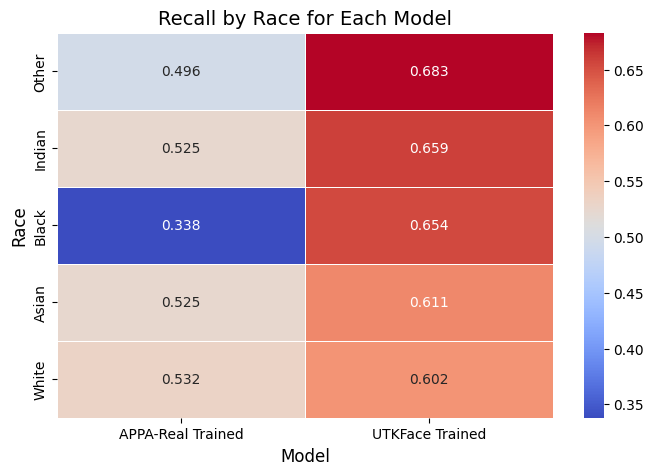

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt


# Choose the metric you want to sort by
metric_to_sort = "recall"  # Change to "recall" or "auc_roc" if needed

# Pivot table for F1-score
race_pivot_df = race_df.pivot(index="Race", columns="Model", values=metric_to_sort)

# Sort the rows by highest F1-score across models
race_pivot_df = race_pivot_df.sort_values(by=race_pivot_df.columns.max(), ascending=False)

# Create a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(race_pivot_df, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)

# Labels and title
plt.title(f"{metric_to_sort.capitalize()} by Race for Each Model", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Race", fontsize=12)

# Show the heatmap
plt.show()


## Regression Model